# Network-Based Detection of Trojan Malware Using Machine Learning


## Changelog

In order to keep track of what we added to the project at each stage, we will note every update here !


### Stage 1

- Added the online import using kagglehub
- Basic and statistical analysis of the data
- Cleaning of the dataset
- Check the balancing of the dataset
- Apply PCA to our datas
- Implementation of k-fold train-test-split
- Definition and implementation of the metrics
- Implementation of Logistic Regression
- Implementation of SVM
- Implementation of Random Forest
- Implementation of Gradient Boosting

### Stage 2

- Added the changelog
- Added the Compute Time section
- Added the correlation matrix
- Added better interpretation of the results
- Fine tuning of XGBoost using Optuna
- Fine tuning of the Random Forest
- Added AdaBoost model
- Fine tuning of AdaBoost using GridSearch

### Stage 3

- Nearest Centroid model
- Deep learning
- Neural networks basics
- Conclusion and results interpretation


## Imports

We reset the variables and environment at the begining

In [ ]:
%reset -f

In [ ]:
# We will use this cell to keep track of every libraries we used.

import numpy as np # Numpy
import pandas as pd #Pandas
import kagglehub #In order to fetch the dataset and not having to upload it everytime
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Better Visualization and customization
import ipaddress # To manage ip adresses

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
import tensorflow as tf
from tensorflow import keras

In [ ]:
# First of all, let's import the dataset we will use :

path = kagglehub.dataset_download("subhajournal/trojan-detection")
print("The dataset has been saved in : ", path+"/Trojan_Detection.csv")

trojan_data = pd.read_csv(path+"/Trojan_Detection.csv",  delimiter= ',')

The dataset has been saved in :  /root/.cache/kagglehub/datasets/subhajournal/trojan-detection/versions/1/Trojan_Detection.csv


# Analysing and Cleaning Data

Time to analyse the data :

In [ ]:
# Basic overview of the data :

print("Shape of the dataset :", trojan_data.shape)
print("\nDataset Information:\n")
print(trojan_data.info())

# First few rows :

print("\nFirst few rows of the dataset:\n")
print(trojan_data.head())

# Missing values :
print("\nMissing values in each column:\n")
print(trojan_data.isnull().sum())


Shape of the dataset : (177482, 86)

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177482 entries, 0 to 177481
Data columns (total 86 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    177482 non-null  int64  
 1   Flow ID                       177482 non-null  object 
 2    Source IP                    177482 non-null  object 
 3    Source Port                  177482 non-null  int64  
 4    Destination IP               177482 non-null  object 
 5    Destination Port             177482 non-null  int64  
 6    Protocol                     177482 non-null  int64  
 7    Timestamp                    177482 non-null  object 
 8    Flow Duration                177482 non-null  int64  
 9    Total Fwd Packets            177482 non-null  int64  
 10   Total Backward Packets       177482 non-null  int64  
 11  Total Length of Fwd Packets   177482 non-null

### **Dataset Overview**

As we can see the dataset contains **177,482 rows** and **86 columns**, this was a choice of us to choose a quite detailed dataset.

- **Data Types**: The majority of the columns are numeric (int64 or float64), with a few categorical attributes (object type).
- **Memory Usage**: The dataset occupies approximately 116.5 MB in memory, so we can easily work on it.
- **No Missing Values**: None of the columns have missing values, which simplifies preprocessing. But we should still check for incoherent entries (like some 0.0 for example)

### **Key Features and Structure**

The dataset contains a lot of details about network flows, like for the main ones :
- **Traffic identifiers**: Flow ID, Source IP, Destination IP, Source Port, Destination Port, and Protocol.
- **Time-based metrics**: Timestamp and Flow Duration.
- **Packet-based statistics**: Total Fwd Packets, Total Backward Packets, Fwd Packet Length, Bwd Packet Length.
- **Flag-related features**: Several columns represent packet flags like FIN Flag Count, SYN Flag Count, ACK Flag Count. Those are flags used to guide the communication
- **Derived metrics**: Attributes such as Flow Bytes/s, Fwd Packets/s, and Active Mean.

### **Target Variable**
In our case, the column **Class** serves as the target variable, indicating whether a particular network flow is classified as Trojan or Benign. We can easily understand that we face a binary classification problem, where our objective is to detect potentially malicious activity (Trojan traffic) in network data.

### **First Glance at the Data**
By looking at the first few rows, we noticed that :
- Many features have values **consistently set to 0.0** for some entries (Active Mean, Idle Mean). These may represent unused or **irrelevant** metrics for certain flows and we have to take care of it.
- Some features like Timestamp and Flow ID are unlikely to be useful for the modeling without **proper transformation**.
- Numerical columns like Flow Bytes/s and Packet Length Variance uses continuous data, which might need to be **scaled** before we use it.

Now that we have more knowledge about the dataset, let's go further with a bit of **statistical analysis** :



### statistical analysis

In [ ]:
print("\nStatistical Summary of Numerical Columns:\n")
print(trojan_data.describe())


Statistical Summary of Numerical Columns:

          Unnamed: 0    Source Port   Destination Port       Protocol  \
count  177482.000000  177482.000000      177482.000000  177482.000000   
mean    88740.500000   38633.298729        5763.328969       8.295917   
std     51234.784576   18435.832044       15155.981517       4.540501   
min         0.000000       0.000000           0.000000       0.000000   
25%     44370.250000   34156.000000          80.000000       6.000000   
50%     88740.500000   43105.500000         443.000000       6.000000   
75%    133110.750000   52135.000000         443.000000       6.000000   
max    177481.000000   65530.000000       65267.000000      17.000000   

        Flow Duration   Total Fwd Packets   Total Backward Packets  \
count    1.774820e+05       177482.000000            177482.000000   
mean     1.163310e+07            6.743929                 9.908261   
std      2.302798e+07           29.655515               106.401351   
min      2.000000e

Here is the statistical summary of all the dataset's numerical columns. We will use it go gain insight about the **distribution and variability** of the data.

- **Unnamed: 0**: Is an index column ranging from 0 to 177,481. Which is very likely not useful in our case.
- **Flow Duration**: The mean duration of flows is 11,6331 seconds, with a significant standard deviation (indicating variability in flow times). This can be very interesting as Trojan could need a longer flow duration to be downloaded

### Cleaning

We noticed that some values were set to 0.0 and that it could be the "NULL" equivalent in this dataset, let's try to investigate and to **clean as much as possible** our dataset :

<ipython-input-31-4b4d84af436a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


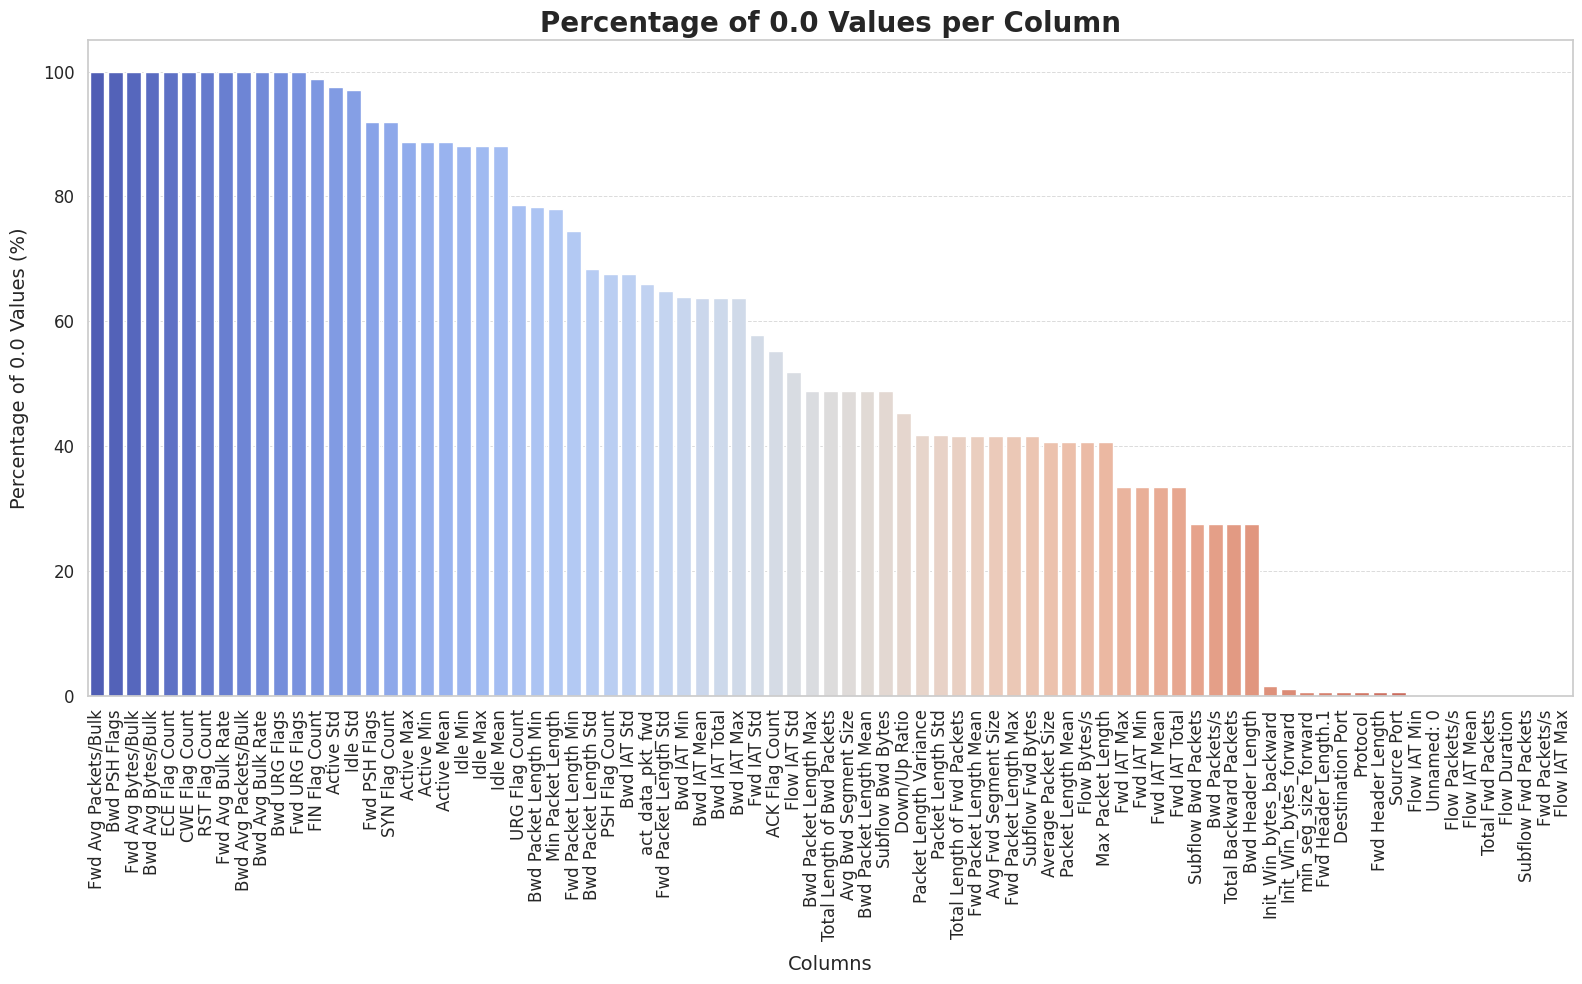

In [ ]:
def plot_zero(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns[numerical_columns != 'Class']  # We exclude the 'Class' column
    zero_counts = (df[numerical_columns] == 0).sum()
    total_rows = len(df)
    zero_percentage = (zero_counts / total_rows) * 100
    high_zero_columns = zero_percentage[zero_percentage >= 50].index.tolist()
    zero_percentage_sorted = zero_percentage.sort_values(ascending=False)

    # Color palette
    palette = sns.color_palette("coolwarm", len(zero_percentage_sorted))
    sns.set(style="whitegrid")

    # Bar plot
    plt.figure(figsize=(16, 10))
    sns.barplot(
        x=zero_percentage_sorted.index,
        y=zero_percentage_sorted.values,
        palette=palette
    )

    # Labels and title
    plt.title('Percentage of 0.0 Values per Column', fontsize=20, fontweight='bold')
    plt.xlabel('Columns', fontsize=14, labelpad=10)
    plt.ylabel('Percentage of 0.0 Values (%)', fontsize=14, labelpad=10)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.tight_layout()
    plt.show()

trojan_data.columns = trojan_data.columns.str.strip()
plot_zero(trojan_data)

As we can see, a lot of columns have a consequent number of '0.0' data.

We do not need these columns in our analysis as we cannot **extract useful data** from them, thus we decided to remove all of the columns having more than **50%** of pseudo-null values (0.0)

In [ ]:
trojan_data['Class'] = trojan_data['Class'].map({'Benign': 0, 'Trojan': 1})
trojan_data['Source IP'] = trojan_data['Source IP'].apply(
    lambda x: int(ipaddress.ip_address(x))
)
trojan_data['Destination IP'] = trojan_data['Destination IP'].apply(
    lambda x: int(ipaddress.ip_address(x))
)

- We also choose to remove the column Unnamed: 0 and Timestamp as they do not convey useful informations.
- When processing the 0.0 problem, we changed the class column to be binary ( in order to use binary classification). **Trojan = 1** and **Benign = 0**.
- Finaly we converted ip adresses to their integer representation, this will make it easier to train on.

In [ ]:
remove = [
    'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Std',
    'Flow IAT Std', 'Fwd IAT Std', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
    'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
    'Min Packet Length', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate', 'act_data_pkt_fwd', 'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Unnamed: 0', 'Timestamp', 'Flow ID'
]

trojan_data.columns = trojan_data.columns.str.strip()
trojan_data = trojan_data.drop(columns=remove, errors='ignore')
print(trojan_data.columns.tolist())

['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Class']



We now have a **much cleaner** dataset

<ipython-input-31-4b4d84af436a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


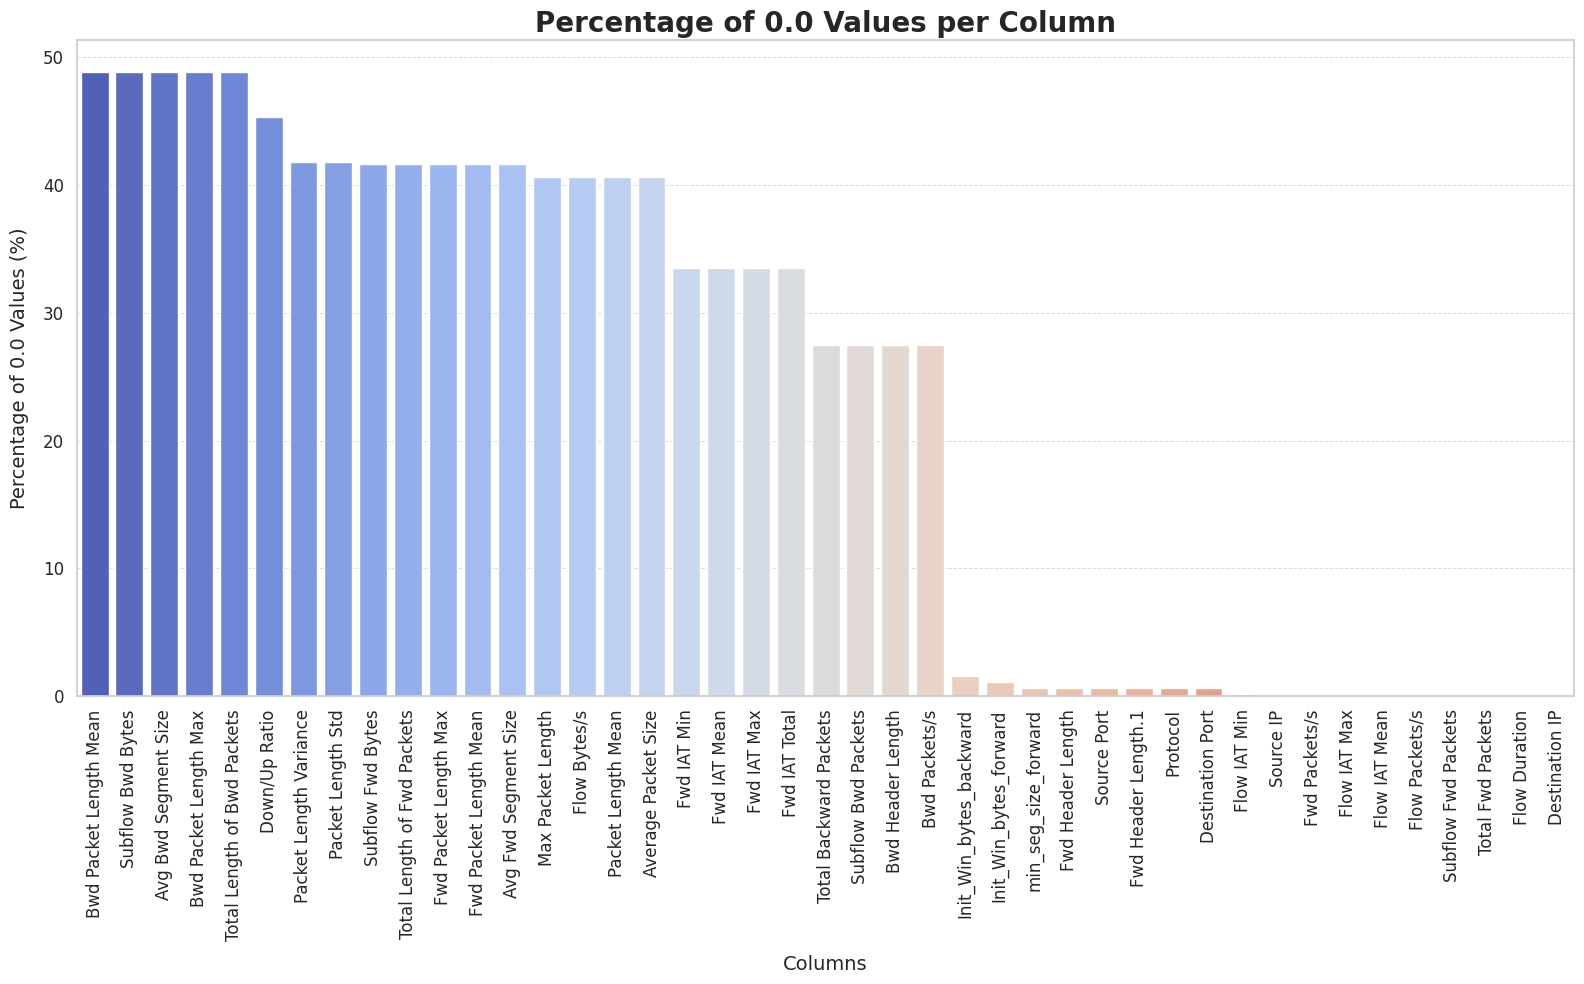

In [ ]:
plot_zero(trojan_data)

### Balancing

Our main goal is to **classify** if the transmisson contains a Trojan or if it is safe, so in our context the target will be the **Class** column.
All the other columns we will use to determine the target are the **features**.

In some situations, like credit fraud, the dataset is **unbalanced** because they represent a very small ammount of all transactions, and we could think the same in our case. Trojan are viruses that should represent a very small partition of all communications, so we should check if **our dataset has already been balanced or not :**

In [ ]:
target = 'Class'
features = [col for col in trojan_data.columns if col != target]

print("\nTarget Column:", target)
print("Feature Columns:", features)
print("\n")

print(trojan_data[target].value_counts(normalize=True))



Target Column: Class
Feature Columns: ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']


Class
1    0.510942
0    0.489058
Name: proportion, dtype: float

By examining the proportions of the Trojan (1) and Benign (0) classes, we can observe that both classes are nearly evenly distributed.

This indicates that the **dataset is balanced**, which is ideal for training as it reduces the risk of bias towards a particular class.

If the dataset was unbalanced, we should have used some techniques like **SMOTE** as seen in class


### Correlation matrix

In order to **visualize the correlation** between all variables, we will build a correlation matrix :

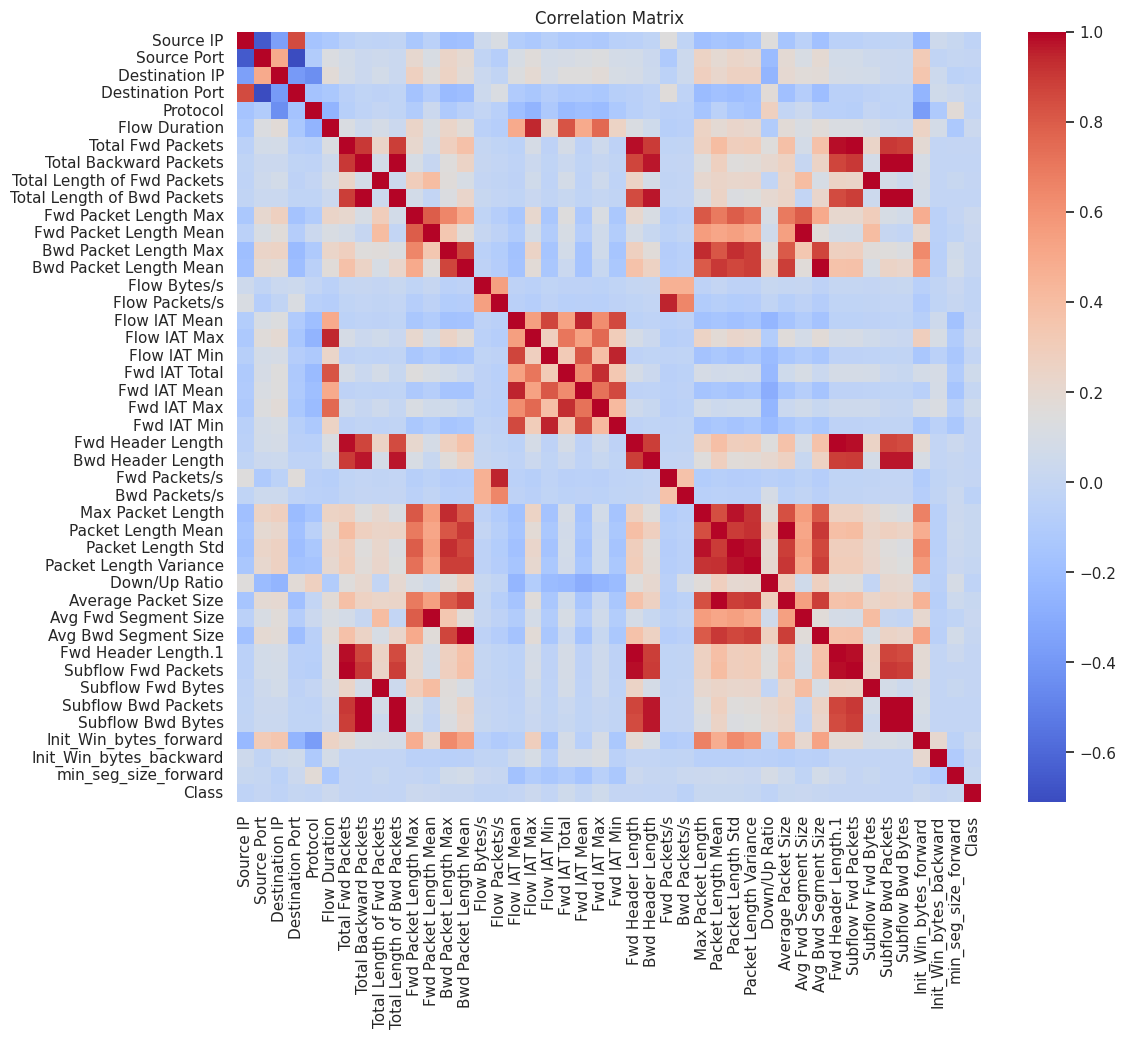

In [ ]:
correlation_matrix = trojan_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix")
plt.show()

We can identify some **cluster of correlated features**, often implying length and sizes of the packets.

For example, Source IP and Destination Port (0.85) show **strong communication links**, while Flow Duration is highly correlated with Flow IAT Max (0.94) and Fwd IAT Total (0.82), indicating a connection between flow **length and timing**.

Plus, Total Fwd Packets is closely related to Fwd Header Length (0.98) and Bwd Header Length (0.90), highlighting the **link between packet size and volume**.

### PCA

We will now use **Principal Component Analysis (PCA)**. It is used to simplify datasets with many features by **reducing dimensionality while retaining most of the data's variance**.

This is essential to **avoid overfitting** and reduce computational complexity. PCA helps identify the most influential combinations of variables !

In [ ]:
features = [col for col in trojan_data.columns if col != target]
X = trojan_data[features]  # We subset the data to include only the columns we want to use
Y = trojan_data['Class']    # We isolate the target column

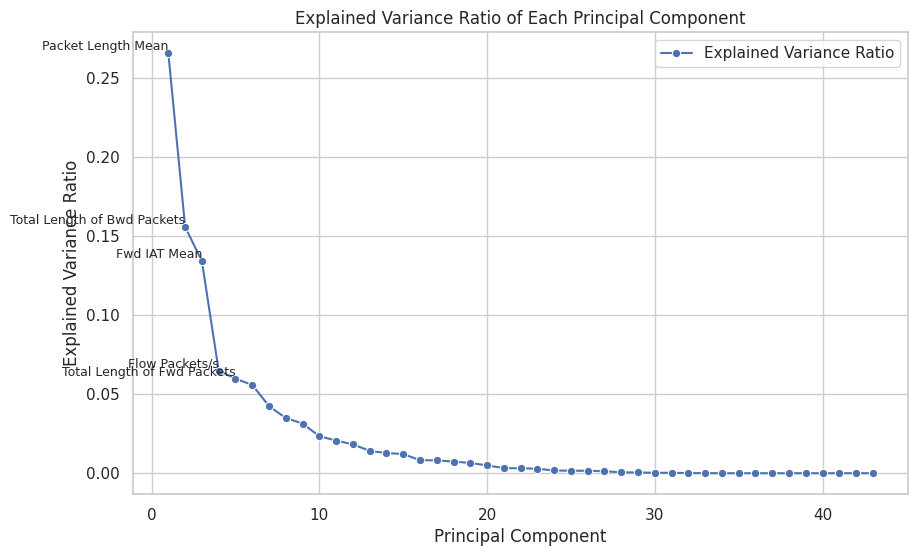

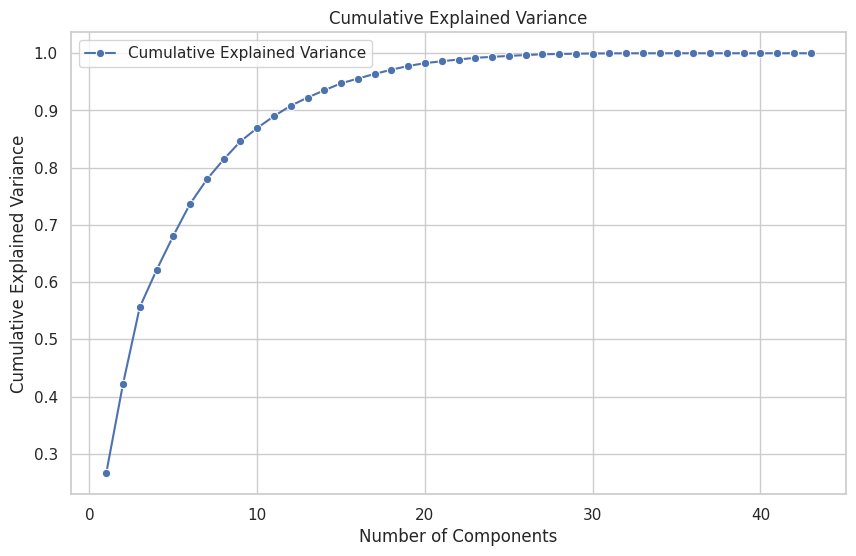

In [ ]:
scaler = StandardScaler()  # We standardize the data
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled) # We apply PCA

# We get the most contributing feature for each principal component
most_contributing_features = []
for i in range(len(pca.components_)):
    top_features = np.argsort(np.abs(pca.components_[i]))[::-1]
    for feature_idx in top_features:
        feature_name = features[feature_idx]
        if feature_name not in most_contributing_features:
            most_contributing_features.append(feature_name)
            break

# We plot the explained variance ratio to understand how much variance each principal component explains
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
             y=pca.explained_variance_ratio_, marker='o', label='Explained Variance Ratio')

# We annotate the points with the most contributing feature for the first five points
for i, (x, y) in enumerate(zip(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)):
    if i < 5:
        plt.text(x, y, most_contributing_features[i], fontsize=9, ha='right', va='bottom')

plt.title("Explained Variance Ratio of Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.legend()
plt.show()

# And then we print the cumulative explained variance to decide how many components to keep
explained_variance_cumulative = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(explained_variance_cumulative) + 1),
             y=explained_variance_cumulative, marker='o', label='Cumulative Explained Variance')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.show()


We can see that most of the variance of the problem is carried by **few features**, like the packet length or the data flow mean.

In order to explain 95% of the variance of the problem, we could **reduce the dimensionality** of the problem to only the first 16 features out of 40, like we can see in the graph !

# Implementation

### Train-Test-Split

To properly evaluate our model and avoid overfitting, splitting the dataset into training, validation, and test sets is essential.

We wanted to use **K-Fold Cross-Validation** as it is an excellent choice to ensure robustness and it allows us to train and validate on different subsets of the data systematically.

We will begin by using this, and then try different machine learning algorithm to solve our **binary classification problem** !

In [ ]:
def cross_validate_model(X, y, model, n_splits=5):
    """
    Function to perform k-fold cross-validation on a given model.

    Parameters:
    - X: Features (input data)
    - y: Target (class labels)
    - model: The model to evaluate
    - n_splits: Number of splits for cross-validation (default is 5)

    Returns:
    - metrics: A dictionary containing accuracy, precision, recall, and F1 score values
    """

    # Convert X to a Pandas DataFrame if it's a NumPy array
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # We initialize Stratified K-Fold
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Explanations :
    # n_splits=n_splits: It determines how many splits the data will be divided into.
    # shuffle=True: Ensures that the data is shuffled before splitting into folds, which helps to avoid bias due to data ordering.
    # random_state=42: Sets the seed for random number generation, ensuring reproducibility of the results across different runs.

    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    # Loop through each fold
    for train_index, test_index in kfold.split(X, y):
        # Split the data into training and testing for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predictions and metrics
        y_pred = model.predict(X_test_scaled)
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['f1_score'].append(f1_score(y_test, y_pred))

    # Summarize performance
    for metric, values in metrics.items():
        print(f"{metric.capitalize()}: {sum(values) / len(values):.2f}")

    return metrics

We can now use this code with **different machine learning algorithm** and check their performances !

### Metrics

We will use different metrics that are crucial for understanding how well our model is making predictions and identifying potential areas for improvement, such as :

**Accuracy**, it measures the overall correctness of the model, the proportion of correct predictions (both positive and negative) among the total predictions.

While accuracy provides a general sense of how well the model is performing, it may not always be a reliable metric.

**Precision** , it focuses on the positive class and measures how many of the predicted positive instances are actually positive. It is important when the cost of false positives (predicting a Trojan when it’s actually benign, for instance) is high.

In our case, it helps to minimize the chances of incorrectly classifying benign instances as Trojans.

**Recall**, it measures how many of the actual positive instances were correctly identified by the model. It is important when the cost of false negatives (missing out on a Trojan, for instance) is critical.

In our application, we want to catch as many Trojans as possible, even if it means some benign instances are misclassified as Trojans.

Finaly the **F1 Score** is the harmonic mean of precision and recall, providing a balance between the two. It is particularly useful when there is a need to balance precision and recall.

After evaluating the model with these metrics, it's important to perform a critical analysis. For example, if we notice that the **precision** is high but **recall** is low, we may conclude that the model is good at predicting positive cases but misses many actual positive cases.

In such a scenario, we may need to adjust the decision threshold or balance the training data to improve recall without sacrificing precision.


## Compute time and ressources

We tried to train a model using all of the following algorithms on our dataset, but we had a **too large volume of data** for a simple google collab.(plus the k-fold cross validation uses more ressources than a basic train-test split)

The **compute time** for random forest and much complex algorithm was about 2 hours, this is why we decided to apply the ACP by default to keep 95% of the variance of ou problem with the first 16 features.

We plan to test basic **neural networks** later on, and to try precise fine tunning, which is why we will probably configure this notebook on a GPU using **CUDA optimization**



In [ ]:
pca = PCA(n_components=16)  # We now only keep the 16 first components
X_pca = pca.fit_transform(X_scaled) # We apply the PCA on our features

## Logistic Regression

Logistic Regression is one of the most **basic algorithms** for binary classification. It works by fitting a linear decision boundary between two classes (in our case, "Trojan" vs. "Benign").

Since it's a relatively simple algorithm, it might not capture complex relationships in the data, but it serves as a **great baseline** for performance comparison.

In [ ]:
model = LogisticRegression(max_iter=1000) #Maximum 1000 iterations

cross_validate_model(X_pca, Y, model)

Accuracy: 0.53
Precision: 0.53
Recall: 0.64
F1_score: 0.58


{'accuracy': [0.5234808575372567,
  0.5292559934642365,
  0.5349898580121704,
  0.5383986928104575,
  0.5295807978363759],
 'precision': [0.5286666041099747,
  0.5332897867773994,
  0.5379673169141953,
  0.5399243011537234,
  0.5332685545067555],
 'recall': [0.6212714340850196,
  0.6302034515079672,
  0.6370954402602415,
  0.6528451698279665,
  0.635476400529334],
 'f1_score': [0.5712402727434032,
  0.577710386656558,
  0.5833501615508885,
  0.59103956071384,
  0.5799033913656033]}

The Logistic Regression model achieved **moderate performance** with an F1 score of 0.57, indicating balanced but limited effectiveness. This is a  **basic and linear algorithm** so this is not a surprise.

## Support Vector Machine (SVM)

The Support Vector Machine (SVM) is a more advanced algorithm that can capture non-linear decision boundaries by using kernel functions. In this case, we used a linear kernel for simplicity. SVM finds a hyperplane that best separates the classes by maximizing the margin between the two classes.

In [ ]:
model = LinearSVC(max_iter=1000) #Maximum 1000 iterations
cross_validate_model(X_pca, Y, model)


Accuracy: 0.53
Precision: 0.53
Recall: 0.64
F1_score: 0.58


{'accuracy': [0.5245231991435896,
  0.5291433078851734,
  0.5345391029975208,
  0.5384268649988732,
  0.5298625197205319],
 'precision': [0.5294392741897769,
  0.5330945625377924,
  0.5376825796817397,
  0.5399416377895313,
  0.5333855943926957],
 'recall': [0.6241936373159839,
  0.6319126647185311,
  0.6352759552296411,
  0.6529554477282753,
  0.6377922364358183],
 'f1_score': [0.5729251012145749,
  0.5783126450701382,
  0.5824192488500227,
  0.5910951382649496,
  0.580935161468535]}

Now the **SVC model with a linear kernel** achieved moderate performance too... with an F1 score of 0.58, indicating reasonable but **not outstanding effectiveness**.

This is not surprising given the nature of the dataset, which contain **complexities beyond what a linear model can capture**.

## Random Forest

A Random Forest is an ensemble method that combines multiple decision trees to create a more robust and accurate classifier. Each decision tree is trained on a random subset of the data, and the final prediction is made by aggregating the predictions from all trees (through majority voting). This reduces the risk of overfitting and helps to capture complex patterns in the data.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
#n_estimators : The number of decision trees in the forest. More trees generally lead to better performance and stability but increase computational cost.
#random_state : Ensures reproducibility of results by setting a random seed.

cross_validate_model(X, Y, model)

Accuracy: 0.80
Precision: 0.82
Recall: 0.78
F1_score: 0.80


{'accuracy': [0.8007437248218159,
  0.8001802969265008,
  0.7988505747126436,
  0.8045977011494253,
  0.7995548794230336],
 'precision': [0.8236601919026445,
  0.8215699976706266,
  0.8210053126277074,
  0.8278304648167661,
  0.8249307152544372],
 'recall': [0.7762033412361471,
  0.777857418536693,
  0.7753763025858742,
  0.7797198941332157,
  0.771393912659903],
 'f1_score': [0.7992279088251156,
  0.7991163725962219,
  0.7975387058356491,
  0.8030552558350843,
  0.7972645676022225]}

The Random Forest model achieved **strong performance**, with an F1 score of 0.80, reflecting a **balanced and effective** model. It shows a good balance between precision (0.82) and recall (0.78), indicating that the model is capable of **correctly identifying** positive instances while minimizing false positives.

This result is **consistent** across multiple cross-validation folds !

## XGBoost

XGBoost is a highly efficient and scalable implementation of gradient boosting that has been successful in many machine learning competitions. It is known for its ability to handle large datasets, regularize the model to avoid overfitting, and provide faster training times compared to traditional gradient boosting methods.

We used XGBoost with 100 estimators and a learning rate of 0.1. This algorithm often provides top-tier performance, especially on structured/tabular data, and its performance is usually superior to traditional machine learning algorithms like Logistic Regression and Random Forest. By using 5-fold cross-validation, we ensured a robust evaluation of the model’s ability to generalize.

In [ ]:
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# n_estimators : The number of boosting stages (trees) to be used. A higher number can improve accuracy but might lead to overfitting.
# learning_rate : Controls the contribution of each tree. A lower learning rate means each tree has less impact, which can improve generalization but may require more trees (n_estimators) to achieve good performance.
#random_state : Ensures reproducibility of results by setting a random seed.

cross_validate_model(X_pca, Y, model)

Accuracy: 0.65
Precision: 0.66
Recall: 0.63
F1_score: 0.65


{'accuracy': [0.650195791193622,
  0.6501394484040904,
  0.6439317106152807,
  0.6449177372098265,
  0.6459319359927879],
 'precision': [0.6651270207852193,
  0.6645751784480773,
  0.6589752486699052,
  0.6585281980742779,
  0.6610179294389821],
 'recall': [0.6351656834096047,
  0.6365440811600596,
  0.6282736946573303,
  0.6335465372739303,
  0.6301830613145126],
 'f1_score': [0.6498011676114731,
  0.6502576811512575,
  0.6432583476812781,
  0.6457958633093526,
  0.6452323152486874]}

Using basic settings we have a F1 score of 0.65, which is **not as good as with random forests.**

But with **some research**, we found out that using the rights **hyperparameters** and with a good **fine tunning**, we could have a way higher F1 score

## Fine tuning of XGBoost

**Fine tuning** involves **optimizing hyperparameters** to maximize model performance and generalization. XGBoost is a powerful algorithm, but its effectiveness can be greatly enhanced by adjusting parameters like n_estimators, learning_rate, max_depth, and subsample.

For fine-tuning we will use **Optuna**, a good library that is optimized for that. By carefully selecting values for parameters like learning_rate (which controls the contribution of each tree), max_depth (which affects tree complexity), and subsample (which reduces overfitting by sampling parts of the data), we can greatly **optimize the model performance.**

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):
    model = xgb.XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        max_depth=trial.suggest_int('max_depth', 3, 9),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        gamma=trial.suggest_float('gamma', 0, 1),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        random_state=42
    )
    f1_scorer = make_scorer(f1_score)
    scores = cross_val_score(model, X_pca, Y, scoring=f1_scorer, cv=3)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best Parameters:", study.best_params)
print("Best F1 Score:", study.best_value)


[I 2024-12-08 12:29:55,164] A new study created in memory with name: no-name-3f419cfa-f838-4391-b46f-6636d08ab6c1
[I 2024-12-08 12:30:55,054] Trial 0 finished with value: 0.6890992667797678 and parameters: {'n_estimators': 433, 'learning_rate': 0.13357377647106683, 'max_depth': 8, 'subsample': 0.761106096139897, 'colsample_bytree': 0.6066794024861346, 'gamma': 0.7264584533550976, 'min_child_weight': 6}. Best is trial 0 with value: 0.6890992667797678.
[I 2024-12-08 12:31:20,923] Trial 1 finished with value: 0.6622047757115451 and parameters: {'n_estimators': 667, 'learning_rate': 0.16337458449314257, 'max_depth': 4, 'subsample': 0.6304422908320952, 'colsample_bytree': 0.9579454084513237, 'gamma': 0.5697901892293046, 'min_child_weight': 3}. Best is trial 0 with value: 0.6890992667797678.
[I 2024-12-08 12:31:42,860] Trial 2 finished with value: 0.6448344901192503 and parameters: {'n_estimators': 441, 'learning_rate': 0.019733494592444854, 'max_depth': 6, 'subsample': 0.8112826236784357, '

Best Parameters: {'n_estimators': 501, 'learning_rate': 0.12353861344968096, 'max_depth': 9, 'subsample': 0.640595554439362, 'colsample_bytree': 0.8658704489369593, 'gamma': 0.8037461535964295, 'min_child_weight': 7}
Best F1 Score: 0.6935271669638693


We found a **F1 Score of 0.69**, which is great ! But we still have better results with the **Random Forest**

## Fine tuning of Random Forest

We will also try to Fine tune the **Random Forest** in order to have a **better score** than the basic 0.80 :

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    # score = cross_val_score(model, X_pca, Y, cv=2, scoring=make_scorer(f1_score)).mean()
    # return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# print("Best hyperparameters:", study.best_params)
# print("Best F1 score:", study.best_value)


As this cell is **really long to run**, we decided to keep the results and to put the execution **in comments**, but here is what we found :

Trial 0 finished with value: 0.6958697753579827

Trial 1 finished with value: 0.6053491307381383

Trial 2 finished with value: 0.705071737844116

Trial 3 finished with value: 0.6249691965393498

Trial 4 finished with value: 0.6851745664104344

Trial 5 finished with value: 0.6731655234055136

...

We did this **30 times**, but no trial managed to have a better score than the **basic parameters** ! (F1 score of 0.80)


## AdaBoost

We also decided to try **AdaBoost** as it was **very popular** on a lot of ML blogs and forum, maybe it could **adapt well to our classification problem** !

In [ ]:
model = AdaBoostClassifier(
    n_estimators=100,  # Number of estimators (trees)
    learning_rate=0.1,  # Learning rate
    algorithm='SAMME', # The new version of the algorithm
    random_state=42    # Random seed for reproducibility
)

cross_validate_model(X_pca, Y, model)

Accuracy: 0.55
Precision: 0.54
Recall: 0.81
F1_score: 0.65


{'accuracy': [0.5544412203848212,
  0.5525819083302814,
  0.5486815415821501,
  0.5541751183231913,
  0.5451881902186162],
 'precision': [0.5423493778053498,
  0.5420128926482095,
  0.5380085460878308,
  0.5424457260404805,
  0.5366553805387899],
 'recall': [0.8194298946904118,
  0.8020069471246623,
  0.8261013398026135,
  0.8142368769298632,
  0.8040361711513013],
 'f1_score': [0.6527009222661396,
  0.6468626317427847,
  0.6516331057278302,
  0.6511166471923984,
  0.6436832347488303]}

We have the **same results** as XGBoost here

## Fine tuning of AdaBoost

We will try to fine tune the model but this time using **Grid Search**, as seen in the course :

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5, 1]  # Learning rate for the model
}

base_model = AdaBoostClassifier(random_state=42)
scorer = make_scorer(f1_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Display progress during training
    n_jobs=-1   # Use all available processors
)

# grid_search.fit(X_pca, Y)
# print("Best Parameters:", grid_search.best_params_)
# print("Best F1 Score:", grid_search.best_score_)


We put this in comment too as it was taking **way too much time**, but we didn't found any better hyperparameters combinations.

Gradient Boosting is good but it didn't seems to **adapt** that much to our problem, so we will try some **more advanced algorithms** and check if the **random forest** is still the best !

# Advanced Implementation

We will now try to use a that is **outside the scope** of the course in order to learn how it works, and we will later try to use some basic **Deep Learning / Neural Networks** models to solve our classification problem.

## Nearest Centroid

We choose to read this **research paper** :

[Nearest Centroid Classifier with Centroid-Based Outlier
Removal for Classification](https://www.researchgate.net/publication/339576432_Nearest_Centroid_Classifier_with_Outlier_Removal_for_Classification/fulltext/5e59bea0a6fdccbeba0b494f/Nearest-Centroid-Classifier-with-Outlier-Removal-for-Classification.pdf)





As it could be interesting in our **classification problem**.

The **Nearest Centroid Classifier** is a simple yet efficient algorithm for classification that calculates the centroid (average) of each class (Trojan and Benign) in the **feature space**.

When used with a network flow, the classifier assigns it to the class whose **centroid is closest to the flow's features**.

Let's try it :

In [ ]:
model = NearestCentroid()

cross_validate_model(X_pca, Y, model)

Accuracy: 0.52
Precision: 0.54
Recall: 0.50
F1_score: 0.52


{'accuracy': [0.5206073752711496,
  0.5232273149843649,
  0.5244534595447374,
  0.527693261212531,
  0.5230730223123732],
 'precision': [0.5326835531691374,
  0.5354948206238661,
  0.5377228257607587,
  0.5403638933050697,
  0.5353813683531687],
 'recall': [0.5032254507360644,
  0.5044935766664829,
  0.49396261785300766,
  0.5060101455668284,
  0.5035288928098809],
 'f1_score': [0.5175356525190666,
  0.519532137179196,
  0.5149146502672567,
  0.5226230815228224,
  0.5189668399965902]}

The score is not that good... But it is specified in the **research paper** that this is a **great baseline model** and it could be hard to train it on complex dataset.

If we compare with the **regression model** we used at the beginning, we have quite the same results, so our **baseline** is confirmed with both models.

## Deep Learning Basics with Neural networks

To improve even more our Trojan detection model, we thougth it could be a good idea to look into the **deep learning** world.

 We found some ressources and tried to implemente a **basic neural network model** with only one hidden layer, using the **TensorFlow/Keras framework**.

  This kind of model can learns **complex patterns** in the data by adjusting the weights and biases of its interconnected nodes. And by leveraging the **non-linear activation** functions within the network, it can capture relationships between features and the target class better.
  
   We used the 'adam' optimizer and 'binary_crossentropy' loss function to train the model, aiming to **minimize prediction errors**.

In [ ]:
# MLP model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_pca.shape[1],)),  # Input layer of 64 units with ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
])

# We compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# We redefine our cross-validation function for deep learning models
def cross_validate_DL(X, y, model, n_splits=5, epochs=10, batch_size=32):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predictions
        y_pred_probs = model.predict(X_test_scaled)
        y_pred = (y_pred_probs > 0.5).astype(int)

        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['f1_score'].append(f1_score(y_test, y_pred))

    for metric, values in metrics.items():
        print(f"{metric.capitalize()}: {sum(values) / len(values):.2f}")

    return metrics

cross_validate_DL(X_pca, Y, model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.63
Precision: 0.66
Recall: 0.58
F1_score: 0.62


{'accuracy': [0.6225033101388849,
  0.6311519283319718,
  0.6331981068289385,
  0.6393396439035385,
  0.6361843588009917],
 'precision': [0.6537288245602648,
  0.6671748641124221,
  0.6515609264853978,
  0.6716437121894709,
  0.6584536958368734],
 'recall': [0.5553288857032586,
  0.5549429343331311,
  0.6064398742901251,
  0.5754300838112042,
  0.5982576091751213],
 'f1_score': [0.6005246839971381,
  0.6059055473617675,
  0.6281912159460848,
  0.6198253845696977,
  0.6269139654475068]}

The F1 Score is not that bad but **we thought it would be better**. As it is only a very basic model this should be normal, but with **more knowledge and some training** we could maybe use Deep Learning to achive **better performances** than the random forest !



## Results Interpretation and conclusion

In our project, we experimented **a lot of machine learning models** to solve our challenge of **Trojan detection**. Our primary goal was to achieve **high accuracy while maintaining a balance** between precision and recall, ensuring that we effectively **identify Trojan** instances without excessively flagging **benign traffic**.

First, we've done a **huge analysis of our dataset**, and we managed to **clean and balance** the data in order to improve future performances.
We also built a **correlation matrix** to see which features were linked, and as we had some **computational ressources** struggles, we decided to use **PCA** to **reduce the complexity** of the problem while **keeping a maximum of the variance**.

Our **first experiments** with simple models like Logistic Regression and Support Vector Machines (SVM) had **moderate results.** These models, while providing a **good baseline** for comparison, struggled to capture the **complex patterns** in network traffic data.


Later on, the **Random Forest** model emerged as a strong model, having **impressive performance** across various evaluation metrics. Its ability to handle **high-dimensional data** and capture **non-linear relationships** was very effective identifying Trojans. We observed a high **F1-score**, indicating a **good balance** between precision and recall.


But we were also intrigued by the potential of **deep learning**, so we implemented a **basic neural network**. This model was **great as a baseline** but we would need more **time and knowledge** to make it better than what we found earlier !

We also explored a **reasearch paper** model, the Nearest Centroid, to assess it's suitability in a **Trojan detection problem**.

Overall, the **Random Forest** and **Gradient Boosting** models achieved the **best results**. So we decided to **Fine-tune** them in order to see if any other **hyperparameters** would lead to **better performances**. But in the end, the best score we could achieve was the basic random forest with a **F1 score of 0.8**, which is **great for our project !**